# Import Packages

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Unzipping Training Data

In [2]:
if not os.path.exists("/kaggle/working/train"):
    !unzip -q /kaggle/input/dogs-vs-cats/train.zip

In [3]:
train_path = '/kaggle/working/train'
len(os.listdir(train_path))

25000

# Some Visualization

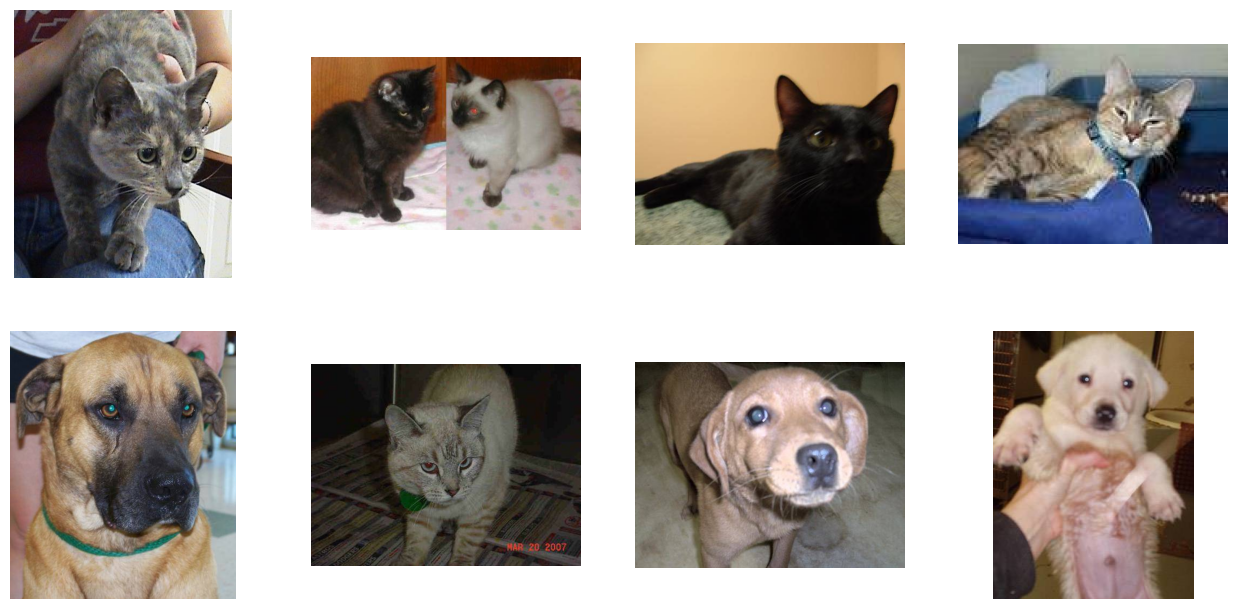

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(16,16))

images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img)) 
    fig.imshow(img) 

In [5]:
os.listdir(train_path)[:20]

['dog.11922.jpg',
 'cat.5471.jpg',
 'dog.8558.jpg',
 'cat.8881.jpg',
 'cat.2765.jpg',
 'dog.9963.jpg',
 'cat.8101.jpg',
 'cat.1863.jpg',
 'dog.10197.jpg',
 'cat.7178.jpg',
 'cat.11292.jpg',
 'cat.408.jpg',
 'dog.10831.jpg',
 'cat.3858.jpg',
 'cat.11000.jpg',
 'cat.9358.jpg',
 'cat.1075.jpg',
 'dog.544.jpg',
 'dog.1603.jpg',
 'dog.6943.jpg']

# Creating Directories to organize our Data

In [6]:
try:
    parent_dir = '/kaggle/working/cats-v-dogs'
    os.mkdir(parent_dir)

    for dir in ['training', 'validation']:
        path = os.path.join(parent_dir , dir)
        os.mkdir(path)
        for dir in ['cats', 'dogs']:
            n_path = os.path.join(path , dir)
            os.mkdir(n_path)
except OSError:
    print('Existed')

In [7]:
src_dir = train_path

cats_train_dir = '/kaggle/working/cats-v-dogs/training/cats'
cats_valid_dir = '/kaggle/working/cats-v-dogs/validation/cats'

dogs_train_dir = '/kaggle/working/cats-v-dogs/training/dogs'
dogs_valid_dir = '/kaggle/working/cats-v-dogs/validation/dogs'

# List of cats names in all training images
cats =[img for img in os.listdir(src_dir) if img[:3] == 'cat']

# List of dogs names in all training images
dogs =[img for img in os.listdir(src_dir) if img[:3] == 'dog']

# Take 10% of training images for validation    
np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [8]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)

    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)

    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [9]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  11250
No. of cats for validation:  1250

No. of ALL dogs :  12500
No. of dogs for training:  11250
No. of dogs for validation:  1250


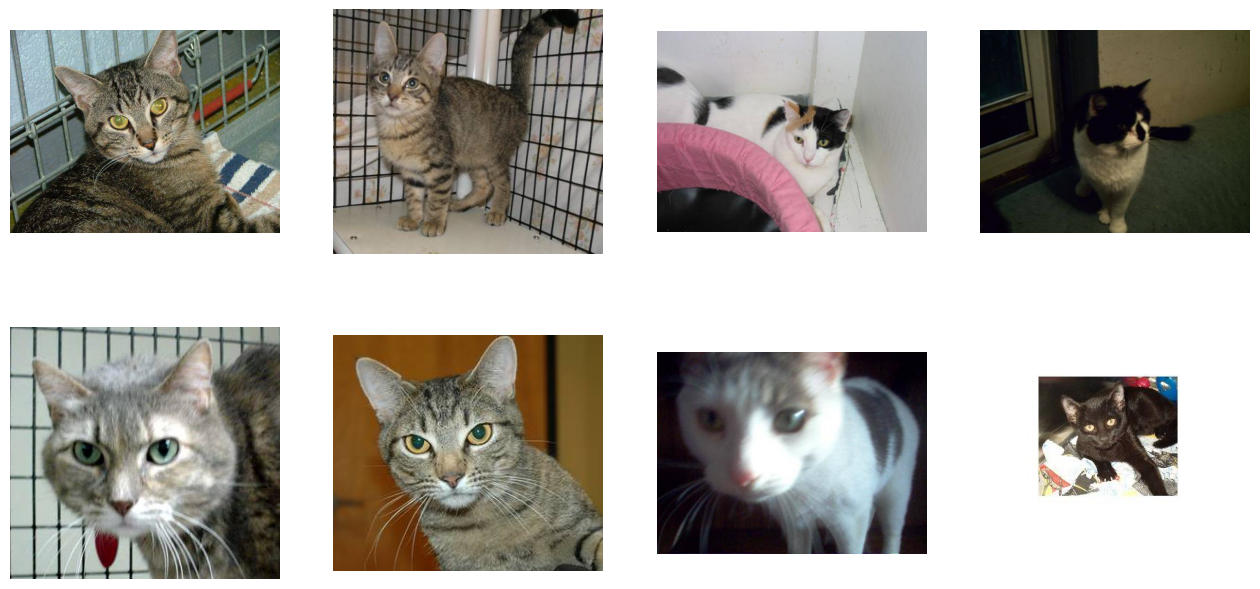

In [10]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

# Image Data Generator
+ **To flow from directory**
+ **Also, we will use it for rescaling**

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)


train_dir = '/kaggle/working/cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_dir = '/kaggle/working/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [12]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


**According to Tensorflow Docs:**
> **Deprecated: *tf.keras.preprocessing.image.ImageDataGenerator* is not recommended for new code. Prefer loading images with *tf.keras.utils.image_dataset_from_directory* and transforming the output *tf.data.Dataset* with preprocessing layers.**
[**Check Here**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

**However, we will stick with ImageDataGenerator for its simplicity**

# Modelling

## Base Model

In [13]:
# create model
model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),

                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')  ])

# Compile model 
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

**We will fit the model for very few epochs, just for defining the least accuracy we can get**

In [14]:
history = model.fit(train_generator, epochs=5, verbose=1,validation_data=valid_generator)

Epoch 1/5
704/704 [==============================] - 54s 54ms/step - loss: 0.6081 - accuracy: 0.6616 - val_loss: 0.5113 - val_accuracy: 0.7424
Epoch 2/5
704/704 [==============================] - 37s 52ms/step - loss: 0.4982 - accuracy: 0.7575 - val_loss: 0.4483 - val_accuracy: 0.8044
Epoch 3/5
704/704 [==============================] - 37s 52ms/step - loss: 0.4291 - accuracy: 0.8022 - val_loss: 0.4309 - val_accuracy: 0.8008
Epoch 4/5
704/704 [==============================] - 36s 51ms/step - loss: 0.3744 - accuracy: 0.8327 - val_loss: 0.3624 - val_accuracy: 0.8376
Epoch 5/5
704/704 [==============================] - 37s 52ms/step - loss: 0.3268 - accuracy: 0.8594 - val_loss: 0.3750 - val_accuracy: 0.8316


<Axes: >

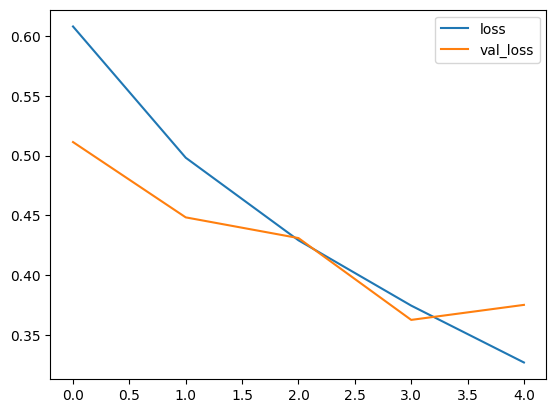

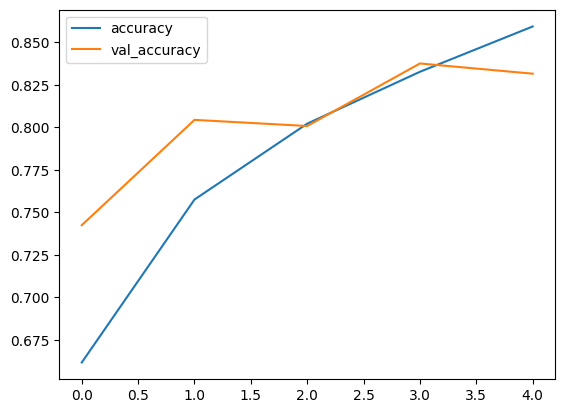

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [16]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Our Base Model Accuracy on Training Data: ", train_acc)
print("Our Base Model Accuracy on Validation Data: ", valid_acc)

79/79 [==============================] - 4s 46ms/step - loss: 0.3750 - accuracy: 0.8316
Our Base Model Accuracy on Training Data:  0.8759555816650391
Our Base Model Accuracy on Validation Data:  0.83160001039505


+ **Some Overfitting**
+ **We will try using Data Augmentation to overcome it**

# Data Augmentation on the fly

* **A technique of artificially increasing the training set by creating modified copies of a dataset using existing data.**
* **Increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation**
* **Enlarge dataset**
* **Avoid Overfitting**


![Augmentation](https://miro.medium.com/v2/resize:fit:960/0*LNtz0G4cngapDH41.png)

**Image Source:** [**Medium Article**](https://medium.com/@tagxdata/data-augmentation-for-computer-vision-9c9ed474291e)

In [17]:
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)

train_dir = '/kaggle/working/cats-v-dogs/training'
aug_train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_dir = '/kaggle/working/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Augmented Model

In [18]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/weights.best.hdf5', monitor='val_loss', save_best_only=True)]

# create model
aug_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),

                            Flatten(),
                            Dense(128, activation='relu'),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/kaggle/working/weights.best.hdf5"):
    aug_model.load_weights("weights.best.hdf5")

# Compile model 
aug_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [19]:
aug_history = aug_model.fit(aug_train_generator, epochs=5, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/5
704/704 [==============================] - 38s 52ms/step - loss: 0.5753 - accuracy: 0.6907 - val_loss: 0.4789 - val_accuracy: 0.7724
Epoch 2/5
704/704 [==============================] - 37s 52ms/step - loss: 0.4706 - accuracy: 0.7764 - val_loss: 0.5772 - val_accuracy: 0.7132
Epoch 3/5
704/704 [==============================] - 37s 52ms/step - loss: 0.4125 - accuracy: 0.8119 - val_loss: 0.4286 - val_accuracy: 0.7888
Epoch 4/5
704/704 [==============================] - 37s 52ms/step - loss: 0.3574 - accuracy: 0.8415 - val_loss: 0.3634 - val_accuracy: 0.8368
Epoch 5/5
704/704 [==============================] - 37s 52ms/step - loss: 0.3167 - accuracy: 0.8639 - val_loss: 0.3358 - val_accuracy: 0.8552


<Axes: >

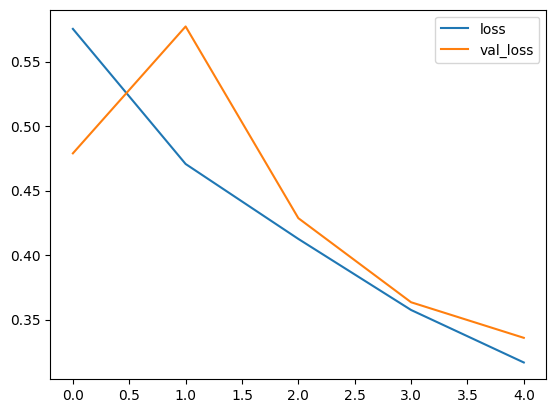

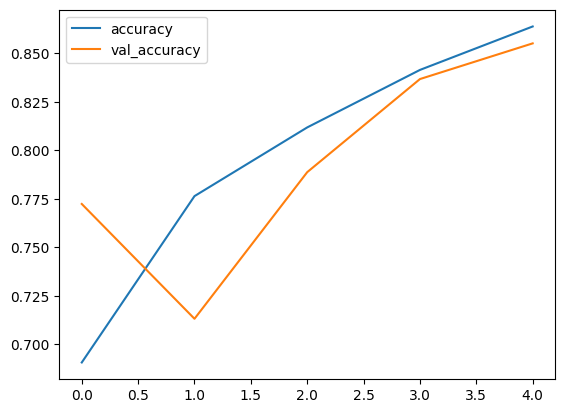

In [20]:
history_df = pd.DataFrame(aug_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [21]:
train_acc = aug_model.evaluate(train_generator)[1]
valid_acc = aug_model.evaluate(valid_generator)[1]
print("Our Augmented Base Model Accuracy on Training Data: ", train_acc)
print("Our Augmented Base Model Accuracy on Validation Data: ", valid_acc)

79/79 [==============================] - 4s 45ms/step - loss: 0.3358 - accuracy: 0.8552
Our Augmented Base Model Accuracy on Training Data:  0.8978666663169861
Our Augmented Base Model Accuracy on Validation Data:  0.8551999926567078


+ **Still Overfitting**
+ **We may try more Regularization**

# More Complex Model
* **More Layers**
* **Batch Normalization**
* **Dropout**

In [22]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/weights2.best.hdf5', monitor='val_loss', save_best_only=True)]

# create model
new_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Flatten(),
                            BatchNormalization(),
                            Dense(128, kernel_regularizer = L2(0.15), bias_regularizer=L2(0.15), activation='relu'),
                            Dropout(rate = 0.5 , seed = 40),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/kaggle/working/weights2.best.hdf5"):
    new_model.load_weights("weights2.best.hdf5")

# Compile model 
new_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

In [23]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 [==============================] - 40s 53ms/step - loss: 1.7557 - accuracy: 0.6910 - val_loss: 0.6660 - val_accuracy: 0.6800
Epoch 2/20
704/704 [==============================] - 37s 52ms/step - loss: 0.5692 - accuracy: 0.7776 - val_loss: 0.5545 - val_accuracy: 0.7760
Epoch 3/20
704/704 [==============================] - 37s 52ms/step - loss: 0.5163 - accuracy: 0.8148 - val_loss: 1.0701 - val_accuracy: 0.5652
Epoch 4/20
704/704 [==============================] - 37s 52ms/step - loss: 0.4782 - accuracy: 0.8409 - val_loss: 0.5106 - val_accuracy: 0.8196
Epoch 5/20
704/704 [==============================] - 37s 52ms/step - loss: 0.4485 - accuracy: 0.8548 - val_loss: 0.4158 - val_accuracy: 0.8768
Epoch 6/20
704/704 [==============================] - 36s 52ms/step - loss: 0.4183 - accuracy: 0.8737 - val_loss: 0.5976 - val_accuracy: 0.7892
Epoch 7/20
704/704 [==============================] - 37s 52ms/step - loss: 0.3966 - accuracy: 0.8853 - val_loss: 0.4647 - val_accuracy:

<Axes: >

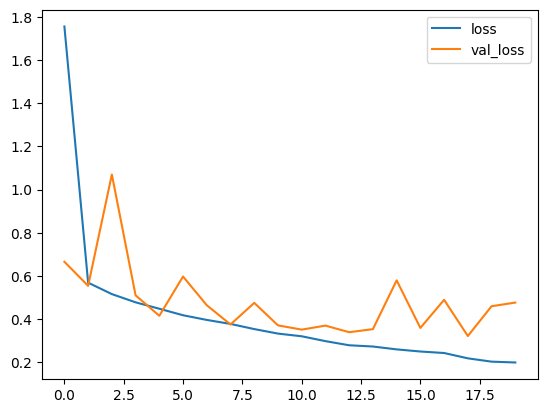

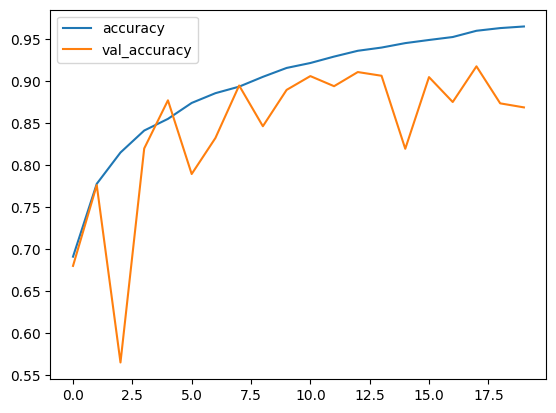

In [24]:
history_df = pd.DataFrame(new_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [25]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

79/79 [==============================] - 4s 45ms/step - loss: 0.4770 - accuracy: 0.8684
Our New Model Accuracy on Training Data:  0.9299111366271973
Our New Model Accuracy on Validation Data:  0.868399977684021


+ **Sounds Good!**
+ **We can go farther use More Epochs**
+ **As we use ModelCheckpoint callback, the model will start from the final best weights stoed before**


In [26]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 [==============================] - 37s 52ms/step - loss: 0.1973 - accuracy: 0.9659 - val_loss: 0.3144 - val_accuracy: 0.9164
Epoch 2/20
704/704 [==============================] - 36s 51ms/step - loss: 0.1732 - accuracy: 0.9726 - val_loss: 0.3592 - val_accuracy: 0.9060
Epoch 3/20
704/704 [==============================] - 37s 52ms/step - loss: 0.1719 - accuracy: 0.9733 - val_loss: 0.3706 - val_accuracy: 0.9032
Epoch 4/20
704/704 [==============================] - 37s 52ms/step - loss: 0.1633 - accuracy: 0.9759 - val_loss: 0.3137 - val_accuracy: 0.9236
Epoch 5/20
704/704 [==============================] - 37s 52ms/step - loss: 0.1723 - accuracy: 0.9730 - val_loss: 0.3212 - val_accuracy: 0.9208
Epoch 6/20
704/704 [==============================] - 37s 53ms/step - loss: 0.1642 - accuracy: 0.9752 - val_loss: 0.3379 - val_accuracy: 0.9160


<Axes: >

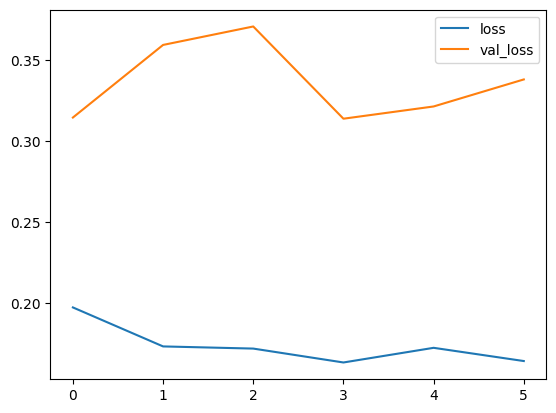

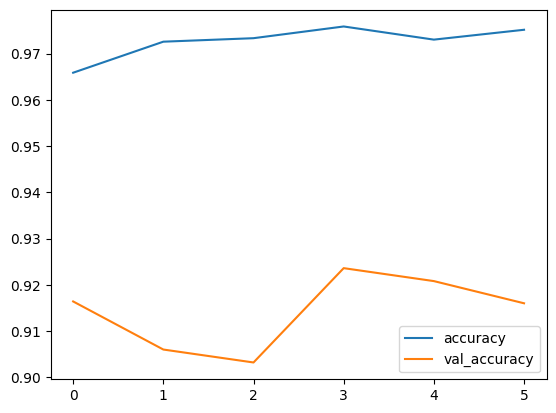

In [27]:
history_df = pd.DataFrame(new_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [28]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

79/79 [==============================] - 4s 45ms/step - loss: 0.3379 - accuracy: 0.9160
Our New Model Accuracy on Training Data:  0.9884889125823975
Our New Model Accuracy on Validation Data:  0.9160000085830688


+ **Nice!**
+ **Let's try Transfer Learning**

# Transfer Learning
+ **A technique where knowledge learned from a task is re-used in order to boost performance on a related task.**
+ **The pre-trained models are usually trained on massive datasets that are a standard benchmark. The weights obtained from the models can be reused in other tasks.**   
+ **Transfer learning is particularly very useful when you have a small training dataset.**  

![](https://cdn-media-1.freecodecamp.org/images/1*tmh4aAYfP-1SGqpqAaim3w.png)

**Image Source:** [**FreeCodeCamp Article**](https://www.freecodecamp.org/news/asl-recognition-using-transfer-learning-918ba054c004/)

 ### Why use transfer learning?

+ **training models with high accuracy requires a lot of data. For example, the ImageNet dataset contains over 1 million images. In the real world, you are unlikely to have such a large dataset.** 
+ **assuming that you had that kind of dataset, you might still not have the resources required to train a model on such a large dataset.**
+ **even if you had the compute resources, you still have to wait for days or weeks to train such a model.** 

### Examples of Pre-trained Models:

+ **training models with high accuracy requires a lot of data. For example, the ImageNet dataset contains over 1 million images. In the real world, you are unlikely to have such a large dataset.** 
+ **assuming that you had that kind of dataset, you might still not have the resources required to train a model on such a large dataset.**
+ **even if you had the compute resources, you still have to wait for days or weeks to train such a model.** 

### How you can use pre-trained models
**There are three ways to use a pre-trained model:**
* **Prediction.**
* **Feature Extraction.**
* **Fine-tuning.**

> **Here, we will use it for Feature Extraction**

### More About Pre-trained Models:
+ [**Keras Docs**](https://keras.io/api/applications/)
+ [**Nice Article**](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96)

**I will use the model included in this [Notebook](http://https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W3/ungraded_lab/C2_W3_Lab_1_transfer_learning.ipynb) from Tensorflow Specialization on Coursera**

In [29]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /kaggle/working//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-06 10:15:32--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/kaggle/working//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/kaggle/working//in 100%[===================>]  83.84M   176MB/s    in 0.5s    

2023-11-06 10:15:32 (176 MB/s) - ‘/kaggle/working//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [31]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                       

In [32]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [33]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)         

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                              

In [34]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [35]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/weights_tf.best.hdf5', monitor='val_loss', save_best_only=True)]

# Train the model.
history = model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 [==============================] - 45s 57ms/step - loss: 0.1210 - accuracy: 0.9536 - val_loss: 0.0805 - val_accuracy: 0.9656
Epoch 2/20
704/704 [==============================] - 39s 55ms/step - loss: 0.0465 - accuracy: 0.9834 - val_loss: 0.0900 - val_accuracy: 0.9680
Epoch 3/20
704/704 [==============================] - 39s 55ms/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.0954 - val_accuracy: 0.9676
Epoch 4/20
704/704 [==============================] - 38s 55ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.1068 - val_accuracy: 0.9712
Epoch 5/20
704/704 [==============================] - 38s 54ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.1297 - val_accuracy: 0.9652
Epoch 6/20
704/704 [==============================] - 38s 54ms/step - loss: 7.9452e-04 - accuracy: 0.9999 - val_loss: 0.1285 - val_accuracy: 0.9696


79/79 [==============================] - 4s 51ms/step - loss: 0.1285 - accuracy: 0.9696
Transfer Learning Model Accuracy on Training Data:  0.9999555349349976
Transfer Learning Model Accuracy on Validation Data:  0.9696000218391418


<Axes: >

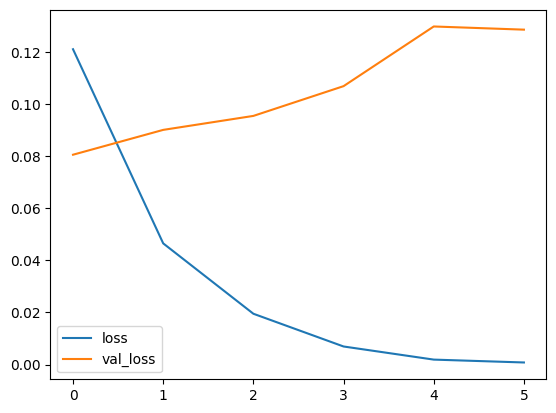

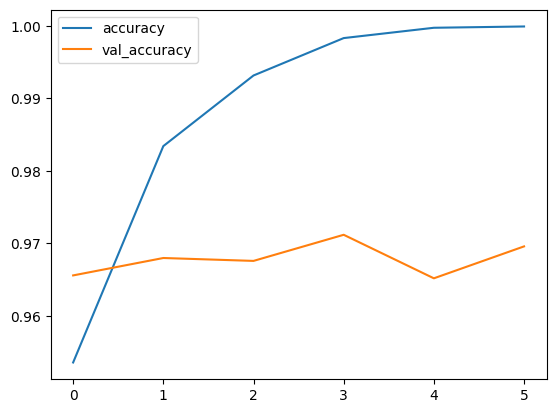

In [36]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Transfer Learning Model Accuracy on Training Data: ", train_acc)
print("Transfer Learning Model Accuracy on Validation Data: ", valid_acc)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

+ **This is the Best Model I have got**
+ **We may need to tune it for Better Performance**
+ **I will get back again to this notebook to update and add illustrations**
+ **I hope you found it useful, if so, please upvote 😀**

In [37]:
model.save('/kaggle/working/inception_model.keras')

# Predictions on Test Data

In [38]:
! unzip -q /kaggle/input/dogs-vs-cats/test1.zip

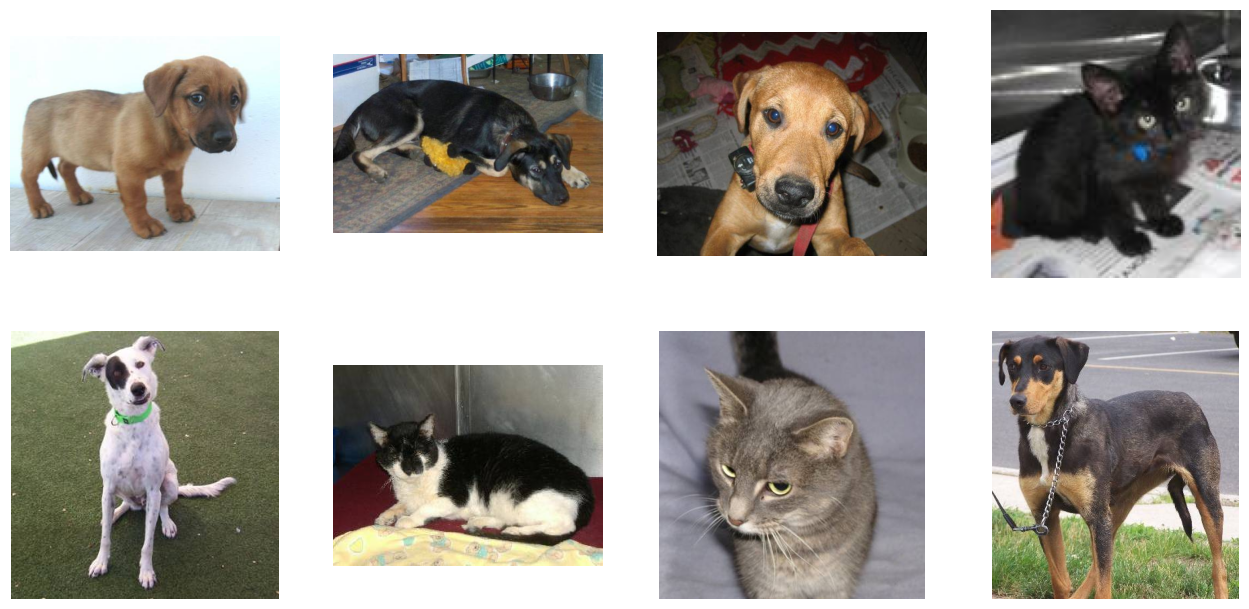

In [39]:
test_dir = '/kaggle/working/test1'

plt.figure(figsize=(16,16))
images = os.listdir(test_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(test_dir, img)) 
    fig.imshow(img) 

## Preparing for Test Images

In [40]:
from tensorflow.keras.preprocessing import image

def convert_one_img(img_folder, img):
  # dimensions of image
    img_width, img_height = 150, 150
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255

    return img

In [41]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/inception_model.keras')

def predict_visualize_img(img_folder, img, model):
    img_fig = mpimg.imread(os.path.join(img_folder, img)) 
    plt.imshow(img_fig)
    
    img_prepared = convert_one_img(img_folder, img)
    pred = model.predict(img_prepared)[0][0]
    if pred <= 0.5:
        result = 'Predicted : Cat'
    else:
        result = 'Predicted : Dog'
    
    plt.title(result)
    return pred

1/1 [==============================] - 2s 2s/step


1.0

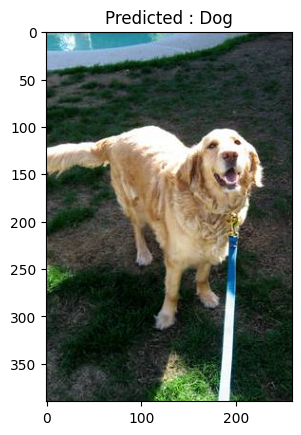

In [42]:
predict_visualize_img(test_dir, os.listdir(test_dir)[10], model)

In [43]:
def convert_imgs_to_tensors(img_folder):

  # load all images into a list
  images = []

  for img in os.listdir(img_folder):
    img = convert_one_img(img_folder, img)
    images.append(img)

  # stack up images list to pass for model
  images = np.vstack(images)

  return images

In [44]:
test_images_prepared = convert_imgs_to_tensors(test_dir)

In [45]:
pred_test_images = (model.predict(test_images_prepared) > 0.5).astype('int')

391/391 [==============================] - 10s 24ms/step


### Create DataFrame Similar to Submission CSV File

In [46]:
test_data = os.listdir(test_dir)
test_df = pd.DataFrame({ "id" : test_data})
test_df['id'] = test_df['id'].str.split('.').str[0]
test_df['label'] = pred_test_images
test_df.head()

,id,label
0,12445,0
1,581,1
2,9839,1
3,9704,0
4,8419,1


In [47]:
test_df.to_csv('/kaggle/working/my_first_preds.csv')